# Fermi-LAT via FermiPyLike

In this Example we show how to use the fermipy plugin in threeML. We perform a Binned likelihood analysis and a Bayesian analysis of the Crab, optimizing the parameters of the Crab Pulsar (PSR J0534+2200) keeping fixed the parameters of the Crab Nebula. In the model, the nebula is described by two sources, one representing the synchrotron spectrum, the othet the Inverse Compton emission.
In this example we show how to download Fermi-LAT data, how to build a model starting from the 4FGL, how to free and fix parameters of the sources in the model, and how to perform a spectral analysis using the fermipy plugin.

In [1]:
import warnings

warnings.simplefilter("ignore")
import numpy as np

np.seterr(all="ignore")
import shutil
from IPython.display import Image, display
import glob
from pathlib import Path
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits as pyfits
import scipy as sp

In [2]:
%%capture
from threeML import *

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()
silence_warnings()

## The Fermi 4FGL catalog
Let's interrogate the 4FGL to get the sources in a radius of 20.0 deg around the Crab

In [4]:
lat_catalog = FermiLATSourceCatalog()

ra, dec, table = lat_catalog.search_around_source("Crab", radius=20.0)

table

19:57:11 INFO      The cache for fermilpsc does not yet exist. We will try to     ]8;id=929610;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=739715;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermilpsc                                  ]8;id=725708;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=306718;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

Trying https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl?table=fermilpsc&


name,source_type,short_source_type,ra,dec,assoc_name,tevcat_assoc,Search_Offset
,,,deg,deg,,,
object,str32,object,float64,float64,object,object,float64
4FGL J0534.5+2200,"pulsar, identified by pulsations",PSR,83.6367,22.0149,PSR J0534+2200,Crab pulsar,0.2093
4FGL J0534.5+2201s,pulsar wind nebula,PWN,83.6331,22.0199,Crab Nebula,Crab,0.3945
4FGL J0534.5+2201i,pulsar wind nebula,PWN,83.6330,22.0200,Crab Nebula,Crab,0.4008
4FGL J0526.3+2246,active galaxy of uncertain type,bcu,81.5908,22.7778,NVSS J052622+224801,,122.2389
4FGL J0544.4+2238,unknown,,86.1093,22.6418,,,142.4970
4FGL J0521.7+2112,BL Lac type of blazar,bll,80.4445,21.2131,TXS 0518+211,VER J0521+211,184.2394
4FGL J0528.3+1817,unknown,unk,82.0946,18.2943,1RXS J052829.6+181657,,239.3750
4FGL J0519.7+1939,unknown,,79.9457,19.6646,,,250.2177


This gets a 3ML model (a Model instance) from the table above, where every source in the 4FGL becomes a Source instance. Note that by default all parameters of all sources are fixed.

In [5]:
model = lat_catalog.get_model()

Let's free all the normalizations within 3 deg from the center.

In [6]:
model.free_point_sources_within_radius(3.0, normalization_only=True)

model.display()

Model summary:
==============

                    N
Point sources     172
Extended sources    0
Particle sources    0

Free parameters (5):
--------------------

                                        value min_value max_value  \
PSR_J0534p2200...K                        0.0       0.0       0.0   
Crab_synch.spectrum.main.Log_parabola.K   0.0       0.0       0.0   
Crab_IC.spectrum.main.Log_parabola.K      0.0       0.0       0.0   
NVSS_J052622p224801...K                   0.0       0.0       0.0   
_4FGL_J0544d4p2238...K                    0.0       0.0       0.0   

                                                   unit  
PSR_J0534p2200...K                       keV-1 s-1 cm-2  
Crab_synch.spectrum.main.Log_parabola.K  keV-1 s-1 cm-2  
Crab_IC.spectrum.main.Log_parabola.K     keV-1 s-1 cm-2  
NVSS_J052622p224801...K                  keV-1 s-1 cm-2  
_4FGL_J0544d4p2238...K                   keV-1 s-1 cm-2  

Fixed parameters (957):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

but then let's fix the sync and the IC components of the Crab nebula (cannot fit them with just one month of data) (these two methods are equivalent)

In [7]:
model["Crab_IC.spectrum.main.Log_parabola.K"].fix = True
model.Crab_synch.spectrum.main.Log_parabola.K.fix = True

However, let's free the index of the Crab Pulsar

In [8]:
model.PSR_J0534p2200.spectrum.main.Super_cutoff_powerlaw.index.free = True

model.display()

Model summary:
==============

                    N
Point sources     172
Extended sources    0
Particle sources    0

Free parameters (4):
--------------------

                            value min_value max_value            unit
PSR_J0534p2200...K            0.0       0.0       0.0  keV-1 s-1 cm-2
PSR_J0534p2200...index  -1.932218     -10.0      10.0                
NVSS_J052622p224801...K       0.0       0.0       0.0  keV-1 s-1 cm-2
_4FGL_J0544d4p2238...K        0.0       0.0       0.0  keV-1 s-1 cm-2

Fixed parameters (958):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [9]:
# Download data from Jan 01 2010 to February 1 2010

tstart = "2010-01-01 00:00:00"
tstop = "2010-02-01 00:00:00"

# Note that this will understand if you already download these files, and will
# not do it twice unless you change your selection or the outdir

evfile, scfile = download_LAT_data(
    ra,
    dec,
    20.0,
    tstart,
    tstop,
    time_type="Gregorian",
    destination_directory="Crab_data",
)

19:57:26 INFO      Query parameters:                                                       ]8;id=62151;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=841207;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 83.6333,22.0133                        ]8;id=887745;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=373772;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=63269;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=853658;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 20.0                                   ]8;id=99531;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=953342;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 2010-01-01 00:00:00,2010-02-01         ]8;id=919196;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=786609;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\
                  00:00:00                                                                                         

         INFO                            timetype = Gregorian                              ]8;id=259732;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=596398;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 30.000,1000000.000                     ]8;id=514313;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=699603;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Photon                                 ]8;id=111894;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=284263;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=737701;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=499395;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=922650;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=678566;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 1d06e9b939821424b65e80e4641be3c8                              ]8;id=929042;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=357818;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

19:57:27 INFO      Estimated complete time for your query: 13 seconds                      ]8;id=271834;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=970927;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#427\427]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=382701;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=477261;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#436\436]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2209281                         
                  55728B4ACFA2F20 (when ready)                                                                     

19:57:33 INFO      Downloading FT1 and FT2 files...                                        ]8;id=128318;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=632239;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#526\526]8;;\

## Configuration for Fermipy

3ML provides and intreface into [Fermipy](https://fermipy.readthedocs.io/en/latest/) via the **FermipyLike** plugin. We can use it to generate basic configuration files.


.. note::
    Currently, the FermipyLike plugin does not provide an interface to handle extended sources. This will change


In [10]:
config = FermipyLike.get_basic_config(
    evfile=evfile,
    scfile=scfile,
    ra=ra,
    dec=dec,
    fermipy_verbosity=1,
    fermitools_chatter=0,
)

# See what we just got

config.display()

binning:
  binsperdec: 8
  binsz: 0.1
  roiwidth: 10.0
data:
  evfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L1d06e9b939821424b65e80e4641be3c8_FT1.fits
  scfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L220928155728B4ACFA2F20_SC00.fits
logging:
  chatter: 0
  verbosity: 1
selection:
  dec: 22.013328116621064
  emax: 100000.0
  emin: 100.0
  evclass: 128
  evtype: 3
  filter: DATA_QUAL>0 && LAT_CONFIG==1
  ra: 83.63334095460648
  tmax: 286675202.0
  tmin: 283996802.0
  zmax: 100.0



binning:
 binsperdec: 8
 binsz: 0.1
 roiwidth: 10.0
data:
 evfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L1d06e9b939821424b65e80e4641be3c8_FT1.fits
 scfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L220928155728B4ACFA2F20_SC00.fits
logging:
 chatter: 0
 verbosity: 1
selection:
 dec: 22.013328116621064
 emax: 100000.0
 emin: 100.0
 evclass: 128
 evtype: 3
 filter: DATA_QUAL>0 && LAT_CONFIG==1
 ra: 83.63334095460648
 tmax: 286675202.0
 tmin: 283996802.0
 zmax: 100.0

You can of course modify the configuration as a dictionary

In [11]:
config["selection"]["emax"] = 300000.0

and even add sections

In [12]:
config["gtlike"] = {"edisp": False}

config.display()

binning:
  binsperdec: 8
  binsz: 0.1
  roiwidth: 10.0
data:
  evfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L1d06e9b939821424b65e80e4641be3c8_FT1.fits
  scfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L220928155728B4ACFA2F20_SC00.fits
gtlike:
  edisp: false
logging:
  chatter: 0
  verbosity: 1
selection:
  dec: 22.013328116621064
  emax: 300000.0
  emin: 100.0
  evclass: 128
  evtype: 3
  filter: DATA_QUAL>0 && LAT_CONFIG==1
  ra: 83.63334095460648
  tmax: 286675202.0
  tmin: 283996802.0
  zmax: 100.0



binning:
 binsperdec: 8
 binsz: 0.1
 roiwidth: 10.0
data:
 evfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L1d06e9b939821424b65e80e4641be3c8_FT1.fits
 scfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L220928155728B4ACFA2F20_SC00.fits
gtlike:
 edisp: false
logging:
 chatter: 0
 verbosity: 1
selection:
 dec: 22.013328116621064
 emax: 300000.0
 emin: 100.0
 evclass: 128
 evtype: 3
 filter: DATA_QUAL>0 && LAT_CONFIG==1
 ra: 83.63334095460648
 tmax: 286675202.0
 tmin: 283996802.0
 zmax: 100.0

### FermipyLike
Let's create an instance of the plugin/ Note that here no processing is made, because fermipy still doesn't know about the model you want to use.



In [13]:
LAT = FermipyLike("LAT", config)

The plugin modifies the configuration as needed to get the output files in a unique place, which will stay the same as long as your selection does not change.

In [14]:
config.display()

binning:
  binsperdec: 8
  binsz: 0.1
  roiwidth: 10.0
data:
  evfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L1d06e9b939821424b65e80e4641be3c8_FT1.fits
  scfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L220928155728B4ACFA2F20_SC00.fits
fileio:
  outdir: __2857f8c8ae391742396bf36e5f946dc1
gtlike:
  edisp: false
logging:
  chatter: 0
  verbosity: 1
selection:
  dec: 22.013328116621064
  emax: 300000.0
  emin: 100.0
  evclass: 128
  evtype: 3
  filter: DATA_QUAL>0 && LAT_CONFIG==1
  ra: 83.63334095460648
  tmax: 286675202.0
  tmin: 283996802.0
  zmax: 100.0



binning:
 binsperdec: 8
 binsz: 0.1
 roiwidth: 10.0
data:
 evfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L1d06e9b939821424b65e80e4641be3c8_FT1.fits
 scfile: /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/Crab_data/L220928155728B4ACFA2F20_SC00.fits
fileio:
 outdir: __2857f8c8ae391742396bf36e5f946dc1
gtlike:
 edisp: false
logging:
 chatter: 0
 verbosity: 1
selection:
 dec: 22.013328116621064
 emax: 300000.0
 emin: 100.0
 evclass: 128
 evtype: 3
 filter: DATA_QUAL>0 && LAT_CONFIG==1
 ra: 83.63334095460648
 tmax: 286675202.0
 tmin: 283996802.0
 zmax: 100.0

Here is where the fermipy processing happens (the .setup method)

In [15]:
fermipy_output_directory = Path(config["fileio"]["outdir"])
print("Fermipy Output directoty: %s" % fermipy_output_directory)

# This remove the output directory, to start a fresh analysis...

if fermipy_output_directory.exists():
    shutil.rmtree(fermipy_output_directory)

# Here is where the fermipy processing happens (the .setup method)

data = DataList(LAT)

jl = JointLikelihood(model, data)

Fermipy Output directoty: __2857f8c8ae391742396bf36e5f946dc1


19:57:47 INFO      Using IRFs P8R3_SOURCE_V3                                                     ]8;id=76628;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermipyLike.py\FermipyLike.py]8;;\:]8;id=73380;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermipyLike.py#109\109]8;;\


Found Galactic template for IRF. P8R3_SOURCE_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 




Found Isotropic template for irf P8R3_SOURCE_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt


20:12:26 INFO      set the minimizer to minuit                                             ]8;id=564228;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=474131;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

The normalization factors of the LAT background components are included in the models as nuisance parameters. They are only added during the previous step (during the model assignment). Let's display them:

In [16]:
for k, v in LAT.nuisance_parameters.items():
    print(k, ":", v)

LAT_isodiff_Normalization : Parameter LAT_isodiff_Normalization = 1.0 []
(min_value = 0.001, max_value = 1000.0, delta = 0.01, free = True)
LAT_galdiff_Prefactor : Parameter LAT_galdiff_Prefactor = 1.0 []
(min_value = 0.1, max_value = 10.0, delta = 0.01, free = True)


We will fix the isotropic BG as we are not sensitive to it with this dataset. We will also fix one more weak source.

In [17]:
model.LAT_isodiff_Normalization.fix = True
model._4FGL_J0544d4p2238.spectrum.main.Powerlaw.K.fix = True
model.display()

Model summary:
==============

                    N
Point sources     172
Extended sources    0
Particle sources    0

Free parameters (4):
--------------------

                            value min_value max_value            unit
PSR_J0534p2200...K            0.0       0.0       0.0  keV-1 s-1 cm-2
PSR_J0534p2200...index  -1.932218     -10.0      10.0                
NVSS_J052622p224801...K       0.0       0.0       0.0  keV-1 s-1 cm-2
LAT_galdiff_Prefactor         1.0       0.1      10.0                

Fixed parameters (960):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

### Performing the fit

In [18]:
jl.set_minimizer("minuit")

res = jl.fit()

         INFO      set the minimizer to MINUIT                                             ]8;id=535006;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=757604;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
PSR_J0534p2200...K,(1.07 +/- 0.04) x 10^-13,1 / (cm2 keV s)
PSR_J0534p2200...index,-1.928 +/- 0.025,
NVSS_J052622p224801.spectrum.main.Powerlaw.K,(5.7 -3.4 +8) x 10^-17,1 / (cm2 keV s)
LAT_galdiff_Prefactor,(9.46 +/- 0.08) x 10^-1,


Correlation matrix:

1.00,0.80,-0.03,-0.07
0.80,1.00,0.06,0.17
-0.03,0.06,1.00,-0.13
-0.07,0.17,-0.13,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT,118120.828792
total,118120.828792


Values of statistical measures:

,statistical measures
AIC,236249.657726
BIC,236291.827763


Now let's compute the errors on the best fit parameters



In [19]:
res = jl.get_errors()

,result,unit
parameter,,
PSR_J0534p2200...K,(1.07 +/- 0.04) x 10^-13,1 / (cm2 keV s)
PSR_J0534p2200...index,-1.928 +/- 0.025,
NVSS_J052622p224801.spectrum.main.Powerlaw.K,(6 -5 +6) x 10^-17,1 / (cm2 keV s)
LAT_galdiff_Prefactor,(9.46 +/- 0.18) x 10^-1,


We might also want to look at the profile of the likelihood for each parameter.

In [20]:
res = jl.get_contours(
    model.PSR_J0534p2200.spectrum.main.Super_cutoff_powerlaw.index, -2.0, -1.6, 30
)

Profiling likelihood:   0%|          | 0/30 [00:00<?, ?it/s]

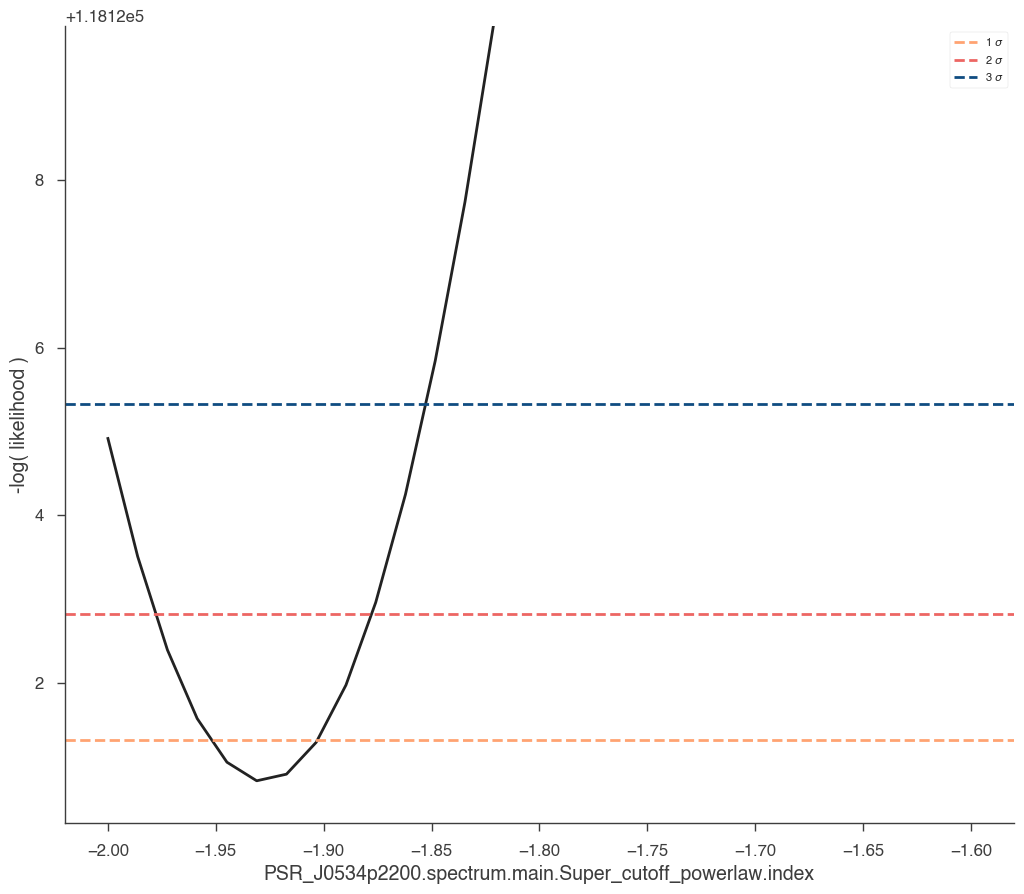

In [21]:
res[-1]

Or we might want to produce a contour plot

In [22]:
res = jl.get_contours(
    "PSR_J0534p2200.spectrum.main.Super_cutoff_powerlaw.K",
    1.6e-13,
    2.2e-13,
    20,
    "PSR_J0534p2200.spectrum.main.Super_cutoff_powerlaw.index",
    -2.0,
    -1.7,
    20,
)

Profiling likelihood:   0%|          | 0/400 [00:00<?, ?it/s]

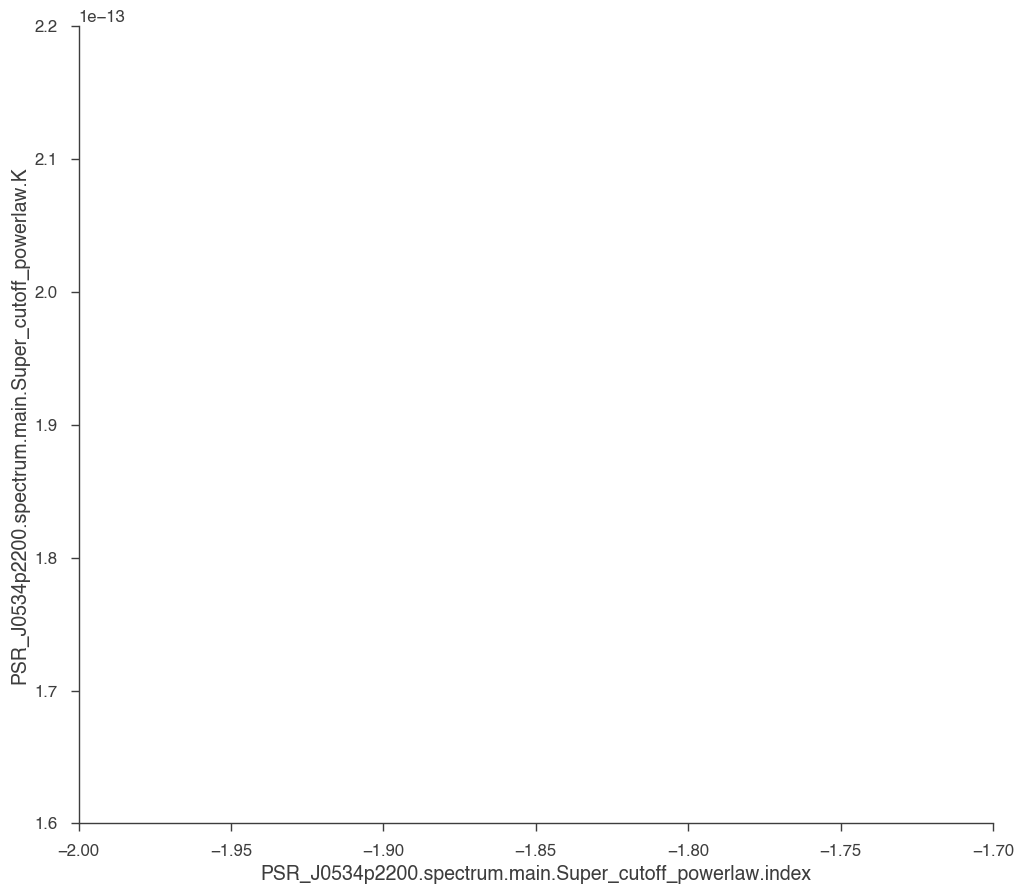

In [23]:
res[-1]

**Pro-trick:** We can also axcess the GTAnalysis object of fermipy:

In [24]:
# res = jl.fit()
# LAT.gta.write_roi('test',make_plots=True)

All the plots are saved in the output directory as png files:



In [25]:
# pngs=Path(f"{fermipy_output_directory}").glob("*png")
# for png in pngs:
#    print(png)
#    my_image=Image(str(png))
#    display(my_image)

We can also plot the resulting model:

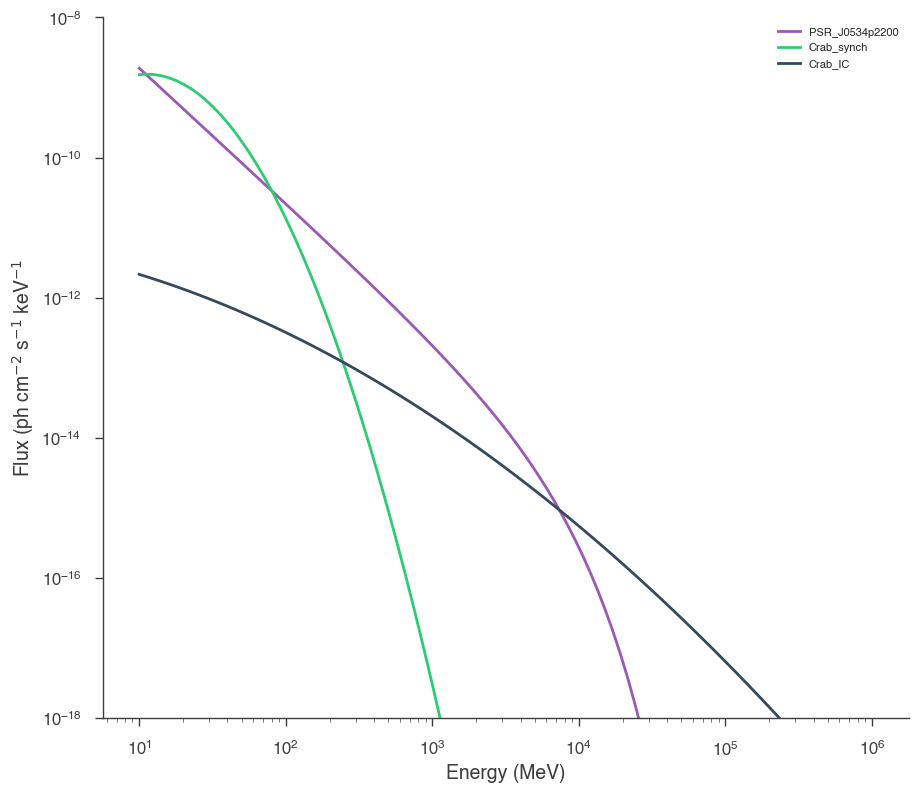

In [26]:
energies = sp.logspace(1, 6, 100) * u.MeV
fig, ax = plt.subplots()
# we only want to visualize the relevant sources...
src_to_plot = ["Crab", "PSR_J0534p2200"]
# Now loop over all point sources and plot them
for source_name, point_source in model.point_sources.items():
    for src in src_to_plot:
        if src in source_name:
            # Plot the sum of all components for this source

            ax.loglog(energies, point_source(energies), label=source_name)
            # If there is more than one component, plot them also separately

            if len(point_source.components) > 1:

                for component_name, component in point_source.components.items():
                    ax.loglog(
                        energies,
                        component.shape(energies),
                        "--",
                        label=f"{component_name} of {source_name}",
                    )

# Add a legend
ax.legend(loc=0, frameon=False)

ax.set_xlabel("Energy (MeV)")
ax.set_ylabel(r"Flux (ph cm$^{-2}$ s$^{-1}$ keV$^{-1}$")
ax.set_ylim([1e-18, 1e-8])

# show the plot
fig

We can also do a bayesian analysis.

This will set priors based on the current defined min-max (log-uniform or uniform).

In [27]:
for param in model.free_parameters.values():

    if param.has_transformation():
        param.set_uninformative_prior(Log_uniform_prior)
    else:
        param.set_uninformative_prior(Uniform_prior)

In [28]:
# It's better to remove the output directory,...
shutil.rmtree(fermipy_output_directory)

bayes = BayesianAnalysis(model, data)

20:40:35 INFO      Using IRFs P8R3_SOURCE_V3                                                     ]8;id=745437;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermipyLike.py\FermipyLike.py]8;;\:]8;id=646416;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermipyLike.py#109\109]8;;\


Found Galactic template for IRF. P8R3_SOURCE_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 




Found Isotropic template for irf P8R3_SOURCE_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_SOURCE_V3_v1.txt


Take care of the nuisance parameters `LAT_isodiff_Normalization` and `LAT_galdiff_Prefactor`, which are only created during the previous step.

In [29]:
model.LAT_isodiff_Normalization.fix = True
model.LAT_galdiff_Prefactor.set_uninformative_prior(Log_uniform_prior)

In [30]:
bayes.set_sampler("emcee")

n_walkers = 10
burn_in = 10
n_samples = 500

bayes.sampler.setup(n_iterations=n_samples, n_burn_in=burn_in, n_walkers=n_walkers)

res = bayes.sample()

20:54:11 INFO      sampler set to emcee                                                    ]8;id=904792;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=707093;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

20:56:47 INFO      Mean acceptance fraction: 0.4518                                            ]8;id=906107;file:///Users/runner/work/threeML/threeML/threeML/bayesian/emcee_sampler.py\emcee_sampler.py]8;;\:]8;id=453345;file:///Users/runner/work/threeML/threeML/threeML/bayesian/emcee_sampler.py#157\157]8;;\

20:56:48 INFO      fit restored to maximum of posterior                                         ]8;id=608846;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=963003;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=67915;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=99741;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
PSR_J0534p2200...K,(1.095 -0.06 +0.030) x 10^-13,1 / (cm2 keV s)
PSR_J0534p2200...index,-1.909 -0.05 +0.009,
NVSS_J052622p224801.spectrum.main.Powerlaw.K,(0.001 +0.008 +6) x 10^-17,1 / (cm2 keV s)
LAT_galdiff_Prefactor,(9.56 -0.24 +0.12) x 10^-1,


Values of -log(posterior) at the minimum:

,-log(posterior)
LAT,-118076.102989
total,-118076.102989


Values of statistical measures:

,statistical measures
AIC,236160.206120
BIC,236202.376157
DIC,236166.213482
PDIC,0.202889


You can access to the parameter range like this (HPD):

In [31]:
this_K = bayes.results.get_variates(
    "PSR_J0534p2200.spectrum.main.Super_cutoff_powerlaw.K"
)
this_idx = bayes.results.get_variates(
    "PSR_J0534p2200.spectrum.main.Super_cutoff_powerlaw.index"
)

print("Highest_posterior_density_intervals :")
print(
    "K (68%%):     %10.2e,%10.2e" % this_K.highest_posterior_density_interval(cl=0.68)
)
print(
    "K (95%%):     %10.2e,%10.2e" % this_K.highest_posterior_density_interval(cl=0.95)
)
print(
    "Index (68%%): %10.2e,%10.2e" % this_idx.highest_posterior_density_interval(cl=0.68)
)
print(
    "Index (95%%): %10.2e,%10.2e" % this_idx.highest_posterior_density_interval(cl=0.95)
)

Highest_posterior_density_intervals :
K (68%):       1.03e-13,  1.12e-13
K (95%):       9.97e-14,  1.17e-13
Index (68%):  -1.96e+00, -1.90e+00
Index (95%):  -1.98e+00, -1.87e+00


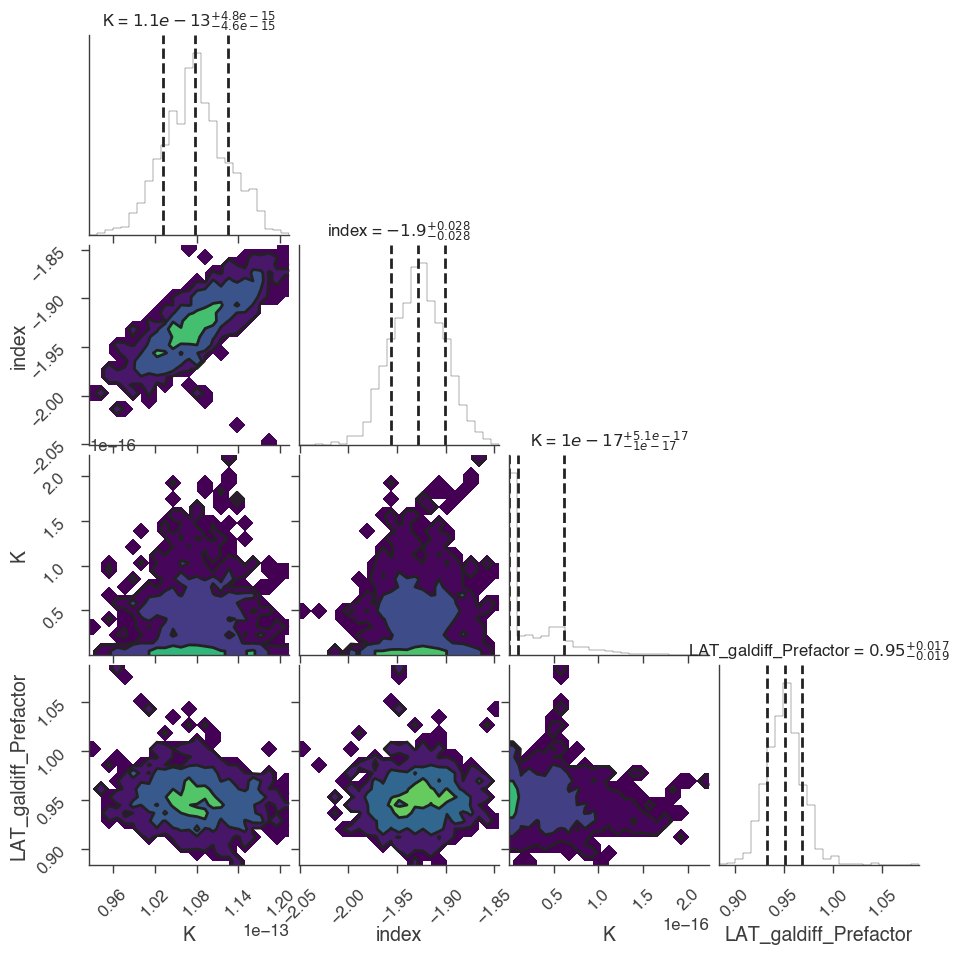

In [32]:
corner_figure = bayes.results.corner_plot()
corner_figure